In [1]:
import pandas as pd
import numpy as np
import string, re, math

#Imports for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#options
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.express as px

## Cleaning CSV Files

**Read in Data**

In [3]:
df1 = pd.read_csv('data/glassdoor_ratings1_62.csv')
df2 = pd.read_csv('data/glassdoor_ratings2_37.csv')
df3 = pd.read_csv('data/glassdoor_ratings3_199.csv')
df4 = pd.read_csv('data/glassdoor_ratings5_797.csv')
df5 = pd.read_csv('data/glassdoor_ratings6_846.csv')
df6 = pd.read_csv('data/glassdoor_ratings7_453.csv')  
df7 = pd.read_csv('data/glassdoor_ratings8_873.csv') #scrape # 8
df8 = pd.read_csv('data/glassdoor_ratings_1to50.csv')
df9 = pd.read_csv('data/glassdoor_ratings_51to200.csv')
df10 = pd.read_csv('data/glassdoor_ratings_501to1k.csv')

#Combine data frames
data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

print('Length of data set: ',len(data))
print('Number of duplicates: ', data['NAME'].duplicated().sum())

Length of data set:  5073
Number of duplicates:  1463


In [4]:
data.head()

,NAME,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION
0,Google,10000+ Employees,"Mountain View, CA",Internet,4.5,4.4,4.4,4.3,4.1,4.5,4.3,"See All 18,362 Reviews",NaN,NaN
1,Microsoft,10000+ Employees,"Redmond, WA",Computer Hardware & Software,4.4,4.4,4.3,4.1,4.0,4.1,4.1,"See All 29,389 Reviews",Our drive to change the world unites us!\n\nMi...,NaN
2,Apple,10000+ Employees,"Cupertino, CA",Computer Hardware & Software,4.3,4.4,4.3,3.7,3.7,4.3,3.8,"See All 20,851 Reviews",We’re a diverse collective of thinkers and doe...,NaN
3,US Air Force,10000+ Employees,"Washington, DC",Federal Agencies,4.2,4.2,4.0,3.3,3.4,4.3,4.2,"See All 16,600 Reviews",The mission of the US Department of the Air Fo...,NaN
4,Cisco Systems,10000+ Employees,"San Jose, CA",Computer Hardware & Software,4.2,4.3,4.3,4.2,3.8,4.1,3.9,"See All 21,804 Reviews","#WeAreCisco, where each person is unique, but ...",Mission: Cisco wants you to bring your uniquen...


### Preliminary Cleaning
 - Handle null values
 - reset indices 
 - drop duplicates

In [5]:
#Reset index to see all rows
data.reset_index(inplace=True)

In [6]:
# #change '  ' to null values
# data['FULL_DESCRIPTION'] = data['FULL_DESCRIPTION'].mask(data['FULL_DESCRIPTION']== '  ')

In [7]:
###Inspect companies with nan description?


In [8]:
#Drop null values from RATING_DI
print('NaN values dropped from RATING_DI: ', data.RATING_DI.isna().sum())
data.dropna(subset=['RATING_DI'], inplace=True)

#Drop null values from DESCRIPTION
print('NaN values dropped from DESCRIPTION: ', data.DESCRIPTION.isna().sum())
data.dropna(subset=['DESCRIPTION'], inplace=True)

NaN values dropped from RATING_DI:  487
NaN values dropped from DESCRIPTION:  166


In [9]:
#Drop duplicate companies by 'NAME' - drops size from 1941 to 1188
print('Duplicates dropped: ', data['NAME'].duplicated().sum())
data.drop_duplicates(subset='NAME', keep='last', inplace=True)
data = data.drop(['index'], axis=1)

Duplicates dropped:  1236


In [10]:
### RESET INDEX HERE TO NAME ### (easier searching?)
data = data.set_index('NAME')

In [11]:
# #reset index to begin at 0
# ###data.reset_index(inplace=True)

# #drop extra indices
# # data = data.drop(['index', 'level_0'], axis=1)
# data = data.drop(['index'], axis=1)


In [12]:
#Check out dataframe
print('Shape: ', data.shape)
data.head(3)

Shape:  (3184, 13)


,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION
NAME,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,"See All 5,198 Reviews",We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,"See All 1,765 Reviews","Cornell is a private, Ivy League university re...",NaN
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,"See All 1,049 Reviews","Dude, let's hit the beach! And then we'll hit ...",NaN


## Feature Engineering
 - Initial cleaning of DESCRIPTION
 - Prepare continuous variables: NUM_REVIEWS, RATING_DI
 - New features: HQ_STATE, defining TARGET variable

### Defining TARGET variable

Text(0.5, 1.0, 'Distribution of Class')

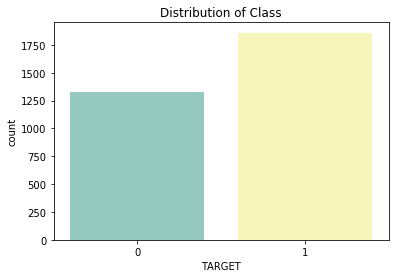

In [13]:
# New column for Target variable - companies with Diversity and Inclusion Rating over 4.0
data['TARGET'] = np.where(data['RATING_DI'] >= 4.0 , 1, 0)

# Checking for class imbalance
sns.countplot(data['TARGET'], palette='Set3').set_title('Distribution of Class')

### New features based on DECRIPTION

In [14]:
# change null values in MISSION and DESCRIPTION to ' '
data['MISSION'].fillna(' ', inplace=True)
data['DESCRIPTION'].fillna(' ', inplace=True)

#New column 'FULL_DESCRIPTION'
data['FULL_DESCRIPTION'] = np.add(data['DESCRIPTION'], data['MISSION'])

In [15]:
# New column for length of description
data['DESC_LEN'] = data['FULL_DESCRIPTION'].apply(lambda x: len(x))

### Clean up NUM_REVIEWS column
- return numbers only

In [16]:
def get_digits(s):
    #remove commas
    exclude = set(string.punctuation)
    s = ''.join(num for num in s if num not in exclude)

    #return digits only
    return s.split()[2]

#apply function to NUM_REVIEWS and change datatype to int
data['NUM_REVIEWS'] = data['NUM_REVIEWS'].apply(get_digits).astype(int)

In [17]:
#removing companies with too few reviews ### try changing this threshold to 50?
print('Number of companies dropped:', (data['NUM_REVIEWS'] < 100).sum())
data = data[(data['NUM_REVIEWS'] > 100)]

Number of companies dropped: 342


### New feature based on RATING_DI

**drop lower than xx reviews**

The rating scale used by Glassdoor.com is a scale from 1 to 5. Therefore, we will establish our **Target variable at 4.0**, since that would indicate an "A" rating on this scale.

In [18]:
#Checking out stats for rating columns
data.describe()

,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,TARGET,DESC_LEN
count,2839.000000,2839.00000,2839.000000,2839.000000,2839.000000,2839.000000,2839.000000,2839.000000,2839.000000,2839.00000
mean,3.887707,3.96143,3.825960,3.712751,3.496372,3.659704,3.598485,1096.063755,0.559000,860.51180
std,0.363902,0.54976,0.434593,0.435420,0.464001,0.461724,0.438880,3661.717597,0.496594,413.26004
min,1.900000,1.00000,1.700000,1.500000,1.600000,1.900000,1.900000,101.000000,0.000000,44.00000
25%,3.700000,3.70000,3.600000,3.400000,3.200000,3.400000,3.300000,183.000000,0.000000,628.00000
50%,3.900000,4.00000,3.800000,3.700000,3.500000,3.700000,3.600000,319.000000,1.000000,769.00000
75%,4.100000,4.30000,4.100000,4.000000,3.800000,4.000000,3.900000,790.000000,1.000000,1005.00000
max,5.000000,5.00000,5.000000,5.000000,5.000000,4.900000,4.900000,74692.000000,1.000000,6493.00000


In [19]:
# Checking average Diversity and Inclusion score
data.RATING_DI.mean()

3.961430081014442

In [20]:
data.RATING_OVERALL.mean()

3.8877069390630505

In [21]:
#how many companies are above and below the threshold?
print('Percentage of companpies below threshold:', 
      (len(data[(data['RATING_DI'] <= 4.0)]) / (len(data)))*100)
print('Percentage of companpies above threshold:', 
      (len(data[(data['RATING_DI'] > 4.0)]) / (len(data)))*100)

Percentage of companpies below threshold: 53.53997886579782
Percentage of companpies above threshold: 46.46002113420219


In [22]:
#RATING_DI_BIN
#removing decimal value for data visualization
def truncate(f):
    return math.floor(f * 10 ** 0) / 10 ** 0

data['RATING_DI_BIN'] = data['RATING_DI'].apply(truncate).astype(int)

### New feature based on SIZE

In [23]:
# ## Assigning continuous variable to SIZE column

# conditions = [ 
#     data['SIZE'] == '10000+ Employees',
#     data['SIZE'] == '5001 to 10000 Employees',
#     data['SIZE'] == '1001 to 5000 Employees', 
#     data['SIZE'] == '501 to 1000 Employees',
#     ((data['SIZE'] == '201 to 500 Employees')| (data['SIZE'] == '51 to 200 Employees'))] 

# ## list of choices to be returned if said condition is True
# choices = [
#     5, #10k+
#     4, #5001 to 10k Employees
#     3, #1001 to 5k Employees 
#     2, #500 to 1k
#     1] #fewer than 500 Employees

# data['SIZE_BIN'] = np.select(conditions, choices, default=None)

# #Convert to float
# data['SIZE_BIN'] = data['SIZE_BIN'].astype(float)

In [24]:
## Assigning continuous variable to SIZE column

conditions = [ 
    data['SIZE'] == '10000+ Employees',
    data['SIZE'] == '5001 to 10000 Employees',
    data['SIZE'] == '1001 to 5000 Employees', 
    ((data['SIZE'] == '501 to 1000 Employees')|(data['SIZE'] == '201 to 500 Employees')| (data['SIZE'] == '51 to 200 Employees'))] 

## list of choices to be returned if said condition is True
choices = [
    4, #10k+
    3, #5001 to 10k Employees
    2, #1001 to 5k Employees 
    1] #fewer than 1k Employees

data['SIZE_BIN'] = np.select(conditions, choices, default=None)

#Convert to float
data['SIZE_BIN'] = data['SIZE_BIN'].astype(float)

In [25]:
data.SIZE_BIN.value_counts(normalize=True, sort=False)

4.0    0.261544
3.0    0.128066
2.0    0.305916
1.0    0.304473
Name: SIZE_BIN, dtype: float64

In [26]:
data['HQ_STATE'] = data['LOCATION_HQ'].apply(lambda x: x[-6:])

### New feature based on LOCATION_HQ

In [27]:
# Inspect last characters of LOCATION_HQ to find companies with headquarters outside of the US
data['HQ_STATE'] = data['LOCATION_HQ'].apply(lambda x: x[-2:])

# Check dataframe shape
data.shape #2800

(2839, 19)

In [28]:
# dropping 300 columns not in US
data = data[data['HQ_STATE'].str[0].str.isupper()]

# New dataframe shape
data.shape

(2584, 19)

In [31]:
data['HQ_STATE'].value_counts()[:50]

# condition = [(data)]

CA    466
NY    252
TX    214
IL    147
MA    122
FL    119
VA     95
GA     89
PA     83
NJ     69
OH     66
NC     59
WA     58
DC     54
MD     54
CO     51
MI     51
UT     49
AZ     46
MN     45
TN     41
MO     40
CT     40
WI     38
IN     24
OR     24
NE     22
KS     15
KY     15
AL     13
OK     13
IA     13
SC     12
LA     11
NV     10
RI      8
ID      7
AR      7
DE      6
MS      6
VT      6
ND      5
NH      4
NM      3
MT      3
ME      2
HI      2
PR      2
WV      2
SD      1
Name: HQ_STATE, dtype: int64

Text(0.5, 0, 'Company Headquarters State')

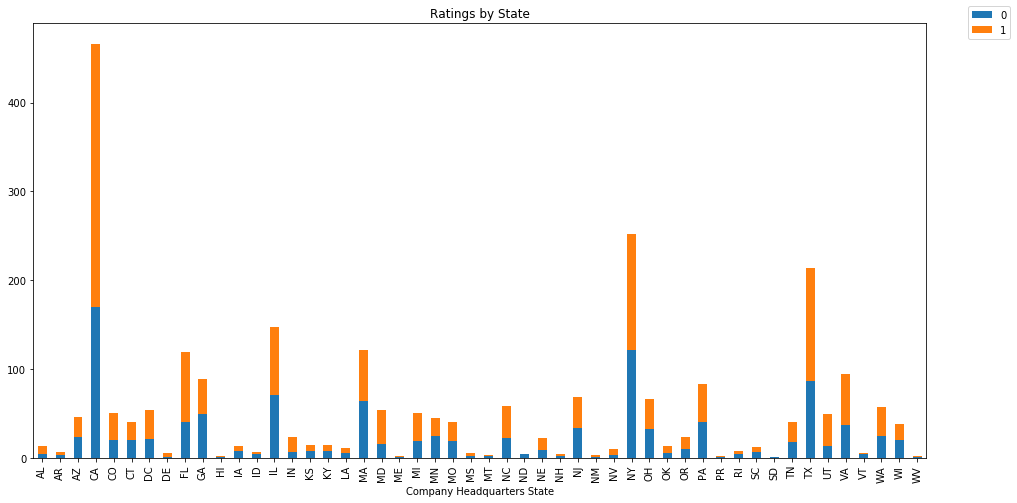

In [32]:
x = data.groupby('HQ_STATE')['TARGET'].value_counts().unstack()

fig,ax = plt.subplots(figsize=(16, 8))
x.plot.bar(stacked=True,ax=ax, label='label')

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Ratings by State')
plt.xlabel('Company Headquarters State')

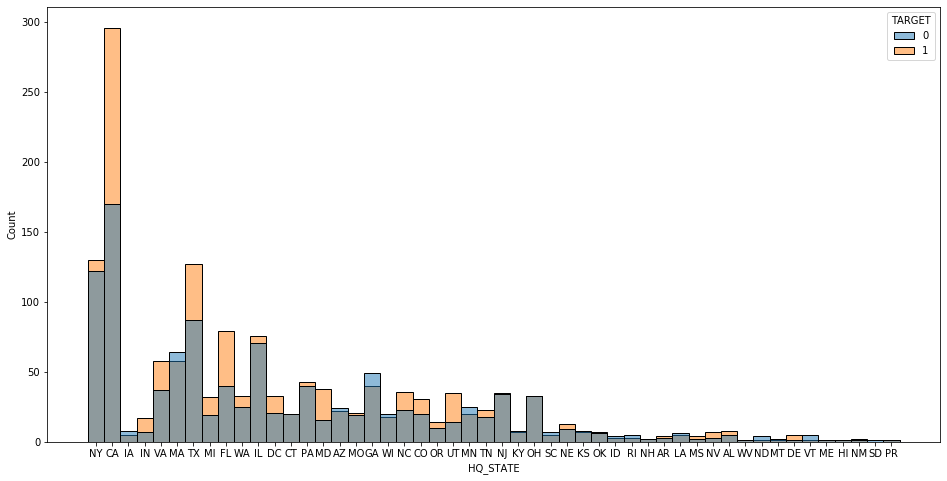

In [59]:
fig, axes = plt.subplots(figsize=(16, 8))

sns.histplot(data = data, x="HQ_STATE", hue = "TARGET")
plt.show()

### Industry

In [142]:
#Most common industries
top_industries = data['INDUSTRY'].value_counts()[:50]
top_industries

Health Care Services & Hospitals           245
Colleges & Universities                    196
Computer Hardware & Software               141
Advertising & Marketing                     99
Enterprise Software & Network Solutions     95
IT Services                                 88
Staffing & Outsourcing                      83
Consulting                                  69
Investment Banking & Asset Management       65
Insurance Carriers                          64
Real Estate                                 59
Internet                                    55
Consumer Products Manufacturing             54
Casual Restaurants                          49
Department, Clothing, & Shoe Stores         48
Banks & Credit Unions                       45
Federal Agencies                            42
Social Assistance                           38
Lending                                     36
Construction                                36
Biotech & Pharmaceuticals                   35
Fast-Food & Q

In [127]:
df = pd.melt(data[["INDUSTRY","TARGET","SIZE"]].groupby(["INDUSTRY","TARGET"]).count().T).sort_values(by='value', ascending=False).head(30)
df


,INDUSTRY,TARGET,value
99,Health Care Services & Hospitals,1,147
38,Colleges & Universities,1,133
98,Health Care Services & Hospitals,0,98
42,Computer Hardware & Software,1,93
37,Colleges & Universities,0,63
66,Enterprise Software & Network Solutions,1,57
3,Advertising & Marketing,1,50
2,Advertising & Marketing,0,49
116,Insurance Carriers,1,49
41,Computer Hardware & Software,0,48


In [161]:
 data.groupby('INDUSTRY')['TARGET'].value_counts(sort=True).sort_values(ascending=False).unstack()

TARGET,0,1
INDUSTRY,,
Accounting,9.0,9.0
Advertising & Marketing,49.0,50.0
Aerospace & Defense,9.0,10.0
Airlines,1.0,4.0
Architectural & Engineering Services,9.0,13.0
...,...,...
Vehicle Dealers,4.0,11.0
Venture Capital & Private Equity,1.0,2.0
Veterinary Services,3.0,2.0


Text(0.5, 0, 'Industry')

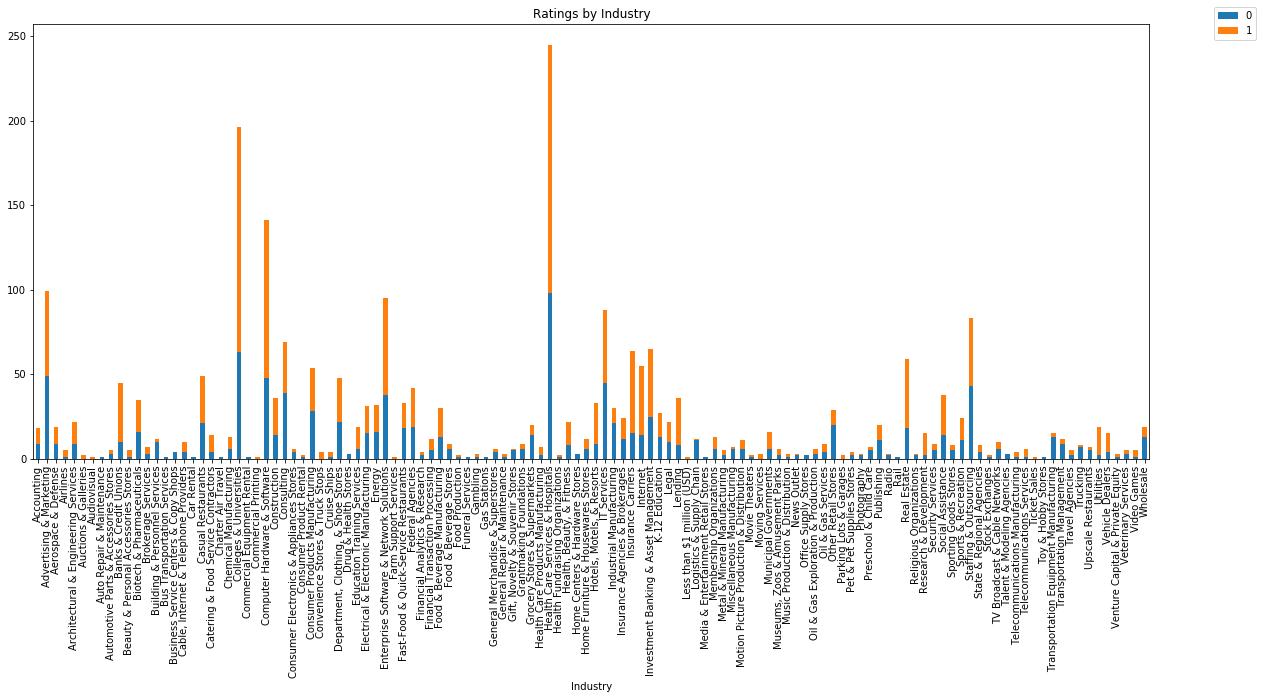

In [138]:
x = data.groupby('INDUSTRY')['TARGET'].value_counts().unstack()

fig,ax = plt.subplots(figsize=(20, 8))
x.plot.bar(stacked=True,ax=ax, label='label')

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Ratings by Industry')
plt.xlabel('Industry')

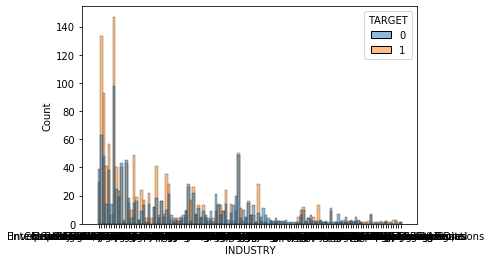

In [77]:

sns.histplot(data = data, x="INDUSTRY", hue = "TARGET")
plt.show()

## EDA on data
**Plots:**
 - scatterplots: DI rating OR target vs 
     - of reviews
     - industry
     - state
     - company size
 - bar plots 
     - industry
     - state
     - size
 
**Additional Notes:**
 - continuous variables: SIZE_BIN, rating columns, NUM_REVIEWS
 - are companies who have more lengthy descriptions more inclusive?

### Inspecting distribution and overall trends

In [34]:
##inspect size column
data.SIZE.value_counts()

1001 to 5000 Employees     812
501 to 1000 Employees      601
10000+ Employees           562
5001 to 10000 Employees    324
51 to 200 Employees        213
1 to 50 Employees           54
Unknown                     10
201 to 500 Employees         8
Name: SIZE, dtype: int64

In [35]:
data.SIZE_BIN.value_counts(normalize=True, sort=False)
#5: 10k+
#4: 5k-10k
#3: 1k-5k
#2: 500-1k, Under 500
#1: Under 500

4.0    0.223016
3.0    0.128571
2.0    0.322222
1.0    0.326190
Name: SIZE_BIN, dtype: float64

In [40]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,TARGET,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,INDUSTRY_COUNT
NAME,,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,1,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,NaN
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,1,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,NaN
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,1,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,NaN


In [41]:
#Checking datatypes for plotting
print(data.info()) #Sanity Check

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, McKinsey & Company to Brooks Running
Data columns (total 20 columns):
SIZE                2584 non-null object
LOCATION_HQ         2584 non-null object
INDUSTRY            2584 non-null object
RATING_OVERALL      2584 non-null float64
RATING_DI           2584 non-null float64
RATING_CV           2584 non-null float64
RATING_WL           2584 non-null float64
RATING_SM           2584 non-null float64
RATING_CB           2584 non-null float64
RATING_CO           2584 non-null float64
NUM_REVIEWS         2584 non-null int64
DESCRIPTION         2584 non-null object
MISSION             2584 non-null object
TARGET              2584 non-null int64
FULL_DESCRIPTION    2584 non-null object
DESC_LEN            2584 non-null int64
RATING_DI_BIN       2584 non-null int64
SIZE_BIN            2520 non-null float64
HQ_STATE            2584 non-null object
INDUSTRY_COUNT      0 non-null float64
dtypes: float64(9), int64(4), object(7)
memory us

In [42]:
# import seaborn as sns
# import matplotlib.pyplot as plt

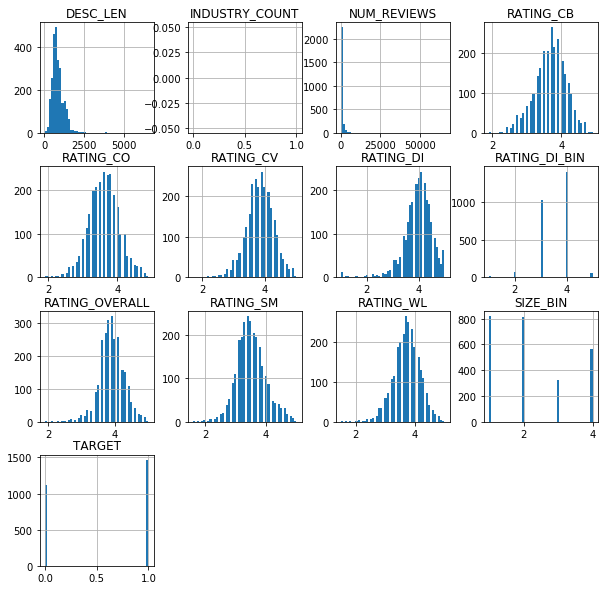

In [43]:
data.hist(bins=50, figsize=(10,10)) #sharex, sharey
plt.show()

Rating distributions are mostly normal

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, McKinsey & Company to Brooks Running
Data columns (total 20 columns):
SIZE                2584 non-null object
LOCATION_HQ         2584 non-null object
INDUSTRY            2584 non-null object
RATING_OVERALL      2584 non-null float64
RATING_DI           2584 non-null float64
RATING_CV           2584 non-null float64
RATING_WL           2584 non-null float64
RATING_SM           2584 non-null float64
RATING_CB           2584 non-null float64
RATING_CO           2584 non-null float64
NUM_REVIEWS         2584 non-null int64
DESCRIPTION         2584 non-null object
MISSION             2584 non-null object
TARGET              2584 non-null int64
FULL_DESCRIPTION    2584 non-null object
DESC_LEN            2584 non-null int64
RATING_DI_BIN       2584 non-null int64
SIZE_BIN            2520 non-null float64
HQ_STATE            2584 non-null object
INDUSTRY_COUNT      0 non-null float64
dtypes: float64(9), int64(4), object(7)
memory us

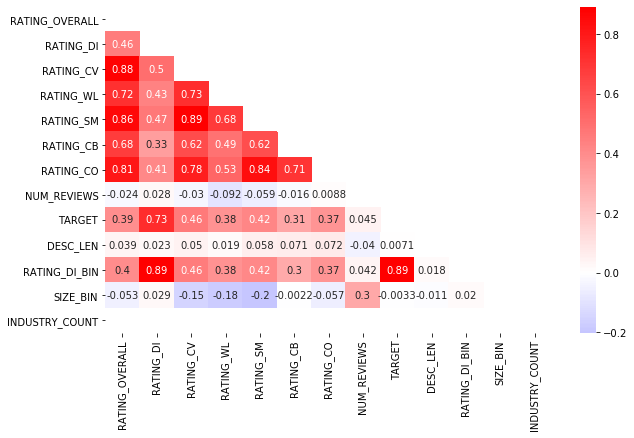

In [44]:
# Looking for any hidden correlations between continuous variables

fig, ax = plt.subplots(figsize=(10, 6))

corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

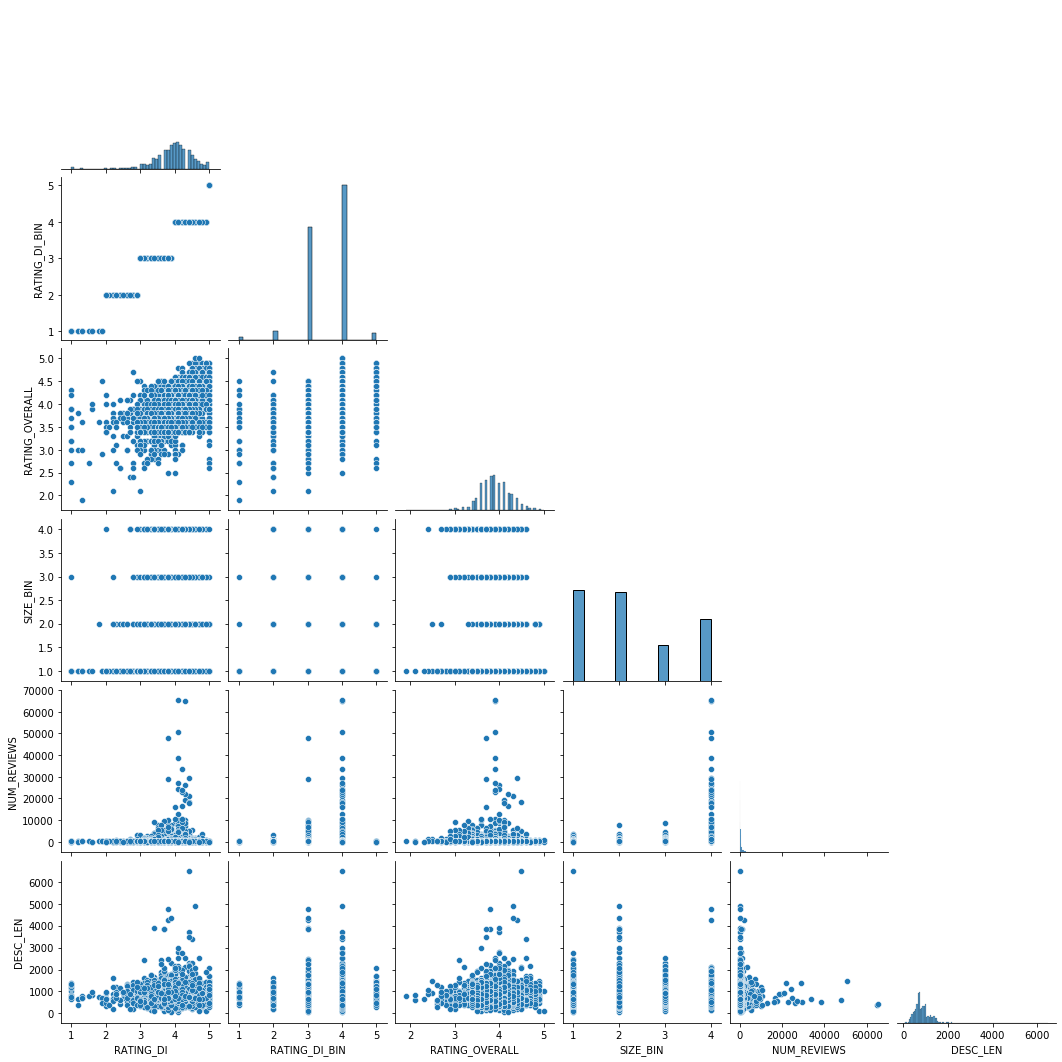

In [45]:
###find a better plot for this (bubbles?)
#continuous variables
sns.pairplot(data[['RATING_DI', 'RATING_DI_BIN', 'RATING_OVERALL', 'SIZE_BIN', 'SIZE', 'NUM_REVIEWS', 'DESC_LEN']], corner=True)


In [46]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,TARGET,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,INDUSTRY_COUNT
NAME,,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,1,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,NaN
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,1,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,NaN
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,1,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,NaN


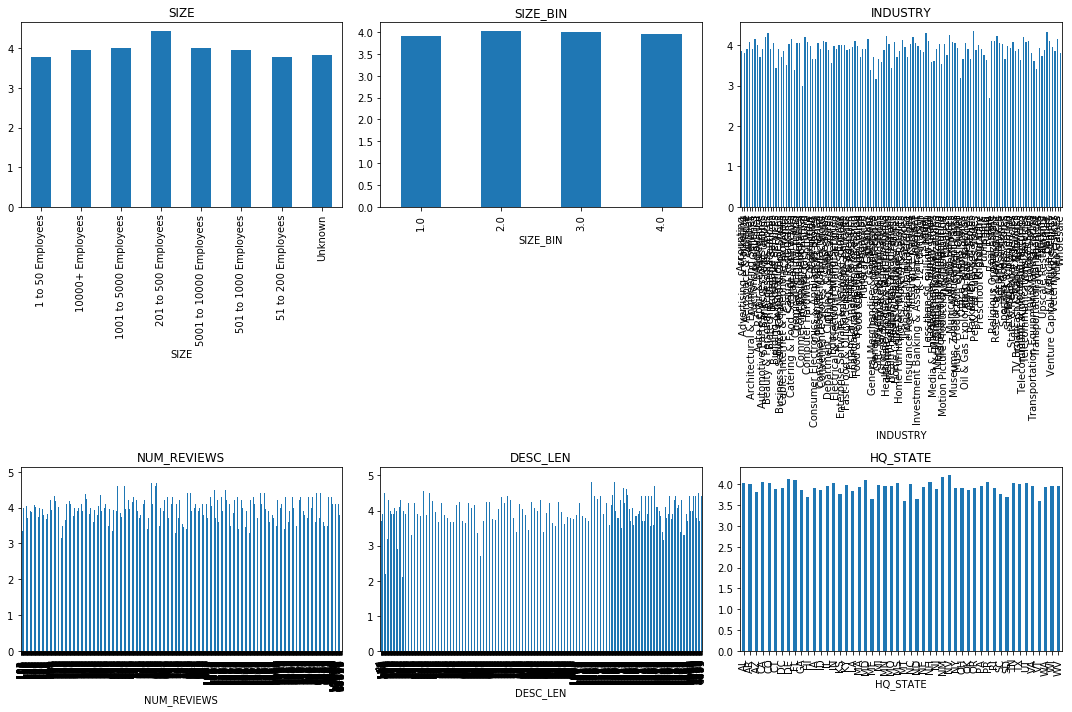

In [47]:
# Bar plots of categorical data
#zipcode explored later
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

categoricals = ['SIZE', 'SIZE_BIN', 'INDUSTRY', 'NUM_REVIEWS', 'DESC_LEN', 'HQ_STATE']

for col, ax in zip(categoricals, axes.flatten()):
    (data.groupby(col)               # group values together by column of interest
         .mean()['RATING_DI']        # take the mean of the saleprice for each group
         .plot
         .bar(ax=ax))                # create a bar graph on the ax    
    ax.set_title(col)                # Make the title the name of the column
fig.tight_layout()

### Exploring Target Variable: Rating

In [48]:
data.SIZE.value_counts()

1001 to 5000 Employees     812
501 to 1000 Employees      601
10000+ Employees           562
5001 to 10000 Employees    324
51 to 200 Employees        213
1 to 50 Employees           54
Unknown                     10
201 to 500 Employees         8
Name: SIZE, dtype: int64

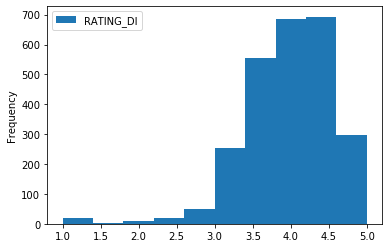

In [49]:
#Distribution of ratings
data.plot(kind='hist', 
          x='SIZE_BIN', 
          y='RATING_DI')
plt.show()

Text(0.5, 0, 'Company Size')

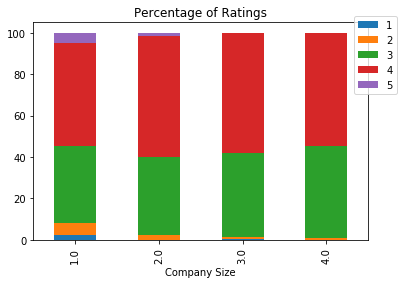

In [50]:
# Percentages (normalize = True)
x = data.groupby('SIZE_BIN')['RATING_DI_BIN'].value_counts(normalize=True).unstack() * 100

fig,ax = plt.subplots()
x.plot.bar(stacked=True,ax=ax,)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Percentage of Ratings')
plt.xlabel('Company Size')

Text(0.5, 0, 'Company Size')

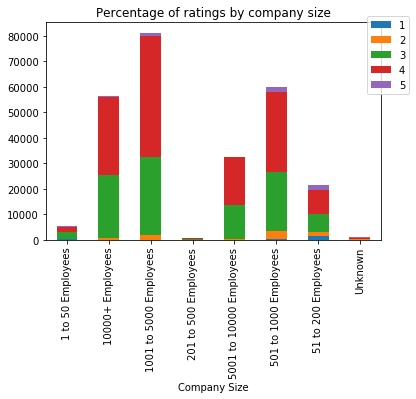

In [51]:
# Percentages (normalize = True)
x = data.groupby('SIZE')['RATING_DI_BIN'].value_counts().unstack() * 100

fig,ax = plt.subplots()
x.plot.bar(stacked=True,ax=ax,)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Percentage of ratings by company size')
plt.xlabel('Company Size')

In [52]:
##Size vs Rating DI
data.groupby('SIZE_BIN')['RATING_OVERALL'].mean()

SIZE_BIN
1.0    3.870316
2.0    3.966626
3.0    3.920679
4.0    3.821530
Name: RATING_OVERALL, dtype: float64

In [53]:
data.groupby('SIZE')['RATING_OVERALL'].mean()

SIZE
1 to 50 Employees          3.768519
10000+ Employees           3.821530
1001 to 5000 Employees     3.966626
201 to 500 Employees       4.412500
5001 to 10000 Employees    3.920679
501 to 1000 Employees      3.926123
51 to 200 Employees        3.692488
Unknown                    3.840000
Name: RATING_OVERALL, dtype: float64

In [54]:
data.SIZE.value_counts()

1001 to 5000 Employees     812
501 to 1000 Employees      601
10000+ Employees           562
5001 to 10000 Employees    324
51 to 200 Employees        213
1 to 50 Employees           54
Unknown                     10
201 to 500 Employees         8
Name: SIZE, dtype: int64

### Inspecting INDUSTRY

In [55]:
print('Number of industries: ', len(data.INDUSTRY.unique())) #126

# Uncomment below line to see all industries
#list(data.INDUSTRY.unique())


Number of industries:  122


In [56]:
# Top 50 with value counts
data.INDUSTRY.value_counts()[:50].to_frame()

,INDUSTRY
Health Care Services & Hospitals,245
Colleges & Universities,196
Computer Hardware & Software,141
Advertising & Marketing,99
Enterprise Software & Network Solutions,95
IT Services,88
Staffing & Outsourcing,83
Consulting,69
Investment Banking & Asset Management,65
Insurance Carriers,64


In [ ]:
# Uncomment below line to see bottom 50 industries with value counts
#data.INDUSTRY.value_counts(ascending=True)[:50].to_frame()

## Saving final CSV

In [57]:
data.head(3) #Sanity Check

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,TARGET,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,INDUSTRY_COUNT
NAME,,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,1,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,NaN
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,1,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,NaN
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,1,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,NaN


**Save updated CSV including all features**

In [58]:
data.to_csv('data/glassdoor_ratings_main.csv', index=False)

## Do we need any of the below cells?

**Create and save DTM (document term matrix)**

In [ ]:
# ##This cell creates DF of only clean description and company name - same thing as data.CLEAN_DESCRIPTION
# ## UNNECESSARY STEP?


# # Creating a new df of only CLEAN_DESCRIPTION
# df_clean_description = data[['CLEAN_DESCRIPTION']]

# # Take a look
# df_clean_description.head()

In [ ]:
# #saving for NLP EDA -- DO I NEED THIS??
# df_clean_description.to_csv('data/df_clean_description.csv', index=False)

## EDA on NLP - keep in this notebook? transfer over?
Using data term matrix

In [ ]:
data.head(3)

In [ ]:
from nltk.corpus import stopwords

In [ ]:
## setting stopwords and punctuations
sw_list = stopwords.words('english')
sw_list += list(string.punctuation) #appending to stopwords
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '',
            '-', '–', '—', '--', 'e.g', "'ll", "'ve", "'s",
            'company', 'services', 'world', 'people', 'care', 'health', 'us',
           ]
sw_set = set(sw_list) #list of stop words - why do I need to make it a set?


In [ ]:
data.CLEAN_DESCRIPTION.to_frame().head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Create a document-term matrix using CountVectorizer, and exclude previously defined stopwords

#remove stop words
cv = CountVectorizer(stop_words=sw_list)
data_cv = cv.fit_transform(data.CLEAN_DESCRIPTION)

data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data.CLEAN_DESCRIPTION.index

#create data_dtm
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data.CLEAN_DESCRIPTION.index
data_dtm

In [ ]:
# import pickle

# #Saving for later use
# data_dtm.to_csv('data/dtm.csv', index=False)

# #saving cv stop words
# pickle.dump(cv, open("data/cv_stop.pkl", "wb"))

# #data_stop.to_pickle("dtm_stop.pkl")
# #data_dtm.to_pickle('data/dtm.pkl')

## Notes

Extras:
- test new scraper on "Retail"

Stretch:
- map out the cities for a map
- EDA: are larger companies more likely to be inclusive?
